Задание 6

В этом задании вам нужно изучить, предобработать данные и обучить свою модель на предсказание стоимости недвижимости. Вам предстоит пройти весь путь работы над проектом в DS от начала до конца. Возьмите данные с kaggle соревнования House Prices - Advanced Regression Techniques https://www.kaggle.com/c/house-prices-advanced-regression-techniques. Эта задача очень похожа на ту, над который мы работаем весь курс. Можете продолжать работу в ноутбуке со всем ПЗ, либо перейти на kaggle и работать в публичном ноутбуке, но тогда обязательно прикрепите ссылку на ноутбук, когда полностью решите задачу. План того, что должно присутствовать в вашем решении:

Загрузка данных train.csv
EDA (Первичный визуальный анализ данных)
Предобработка данных (Пропуски, выбросы, масштабирование при необходимости)
Обучение модели
Проверка качества модели (Отложенная выборка, кросс-валидация)
Интерпретация результатов

Подключаем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random

%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from datetime import datetime

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):

  print('Train R2:\t' + str(round(r2(train_true_values, train_pred_values), 3)))
  print('Test R2:\t' + str(round(r2(test_true_values, test_pred_values), 3)))

  plt.figure(figsize=(18, 10))

  plt.subplot(121)
  sns.scatterplot(x=train_pred_values, y=train_true_values)
  plt.xlabel('Predicted values')
  plt.ylabel('True values')
  plt.title('Train sample prediction')

  plt.subplot(122)
  sns.scatterplot(x=test_pred_values, y=test_true_values)
  plt.xlabel('Predicted values')
  plt.ylabel('True values')
  plt.title('Test sample prediction')

  plt.show()

Укажим пути к директориям

In [5]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=",")
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [8]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [9]:
train_df.shape

(10000, 20)

In [10]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep=",")
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [11]:
test_df.shape

(5000, 19)

In [12]:
train_df.shape[1] - 1 == test_df.shape[1]

True

Приведение типов

In [13]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [14]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

1. EDA

Целевая переменная

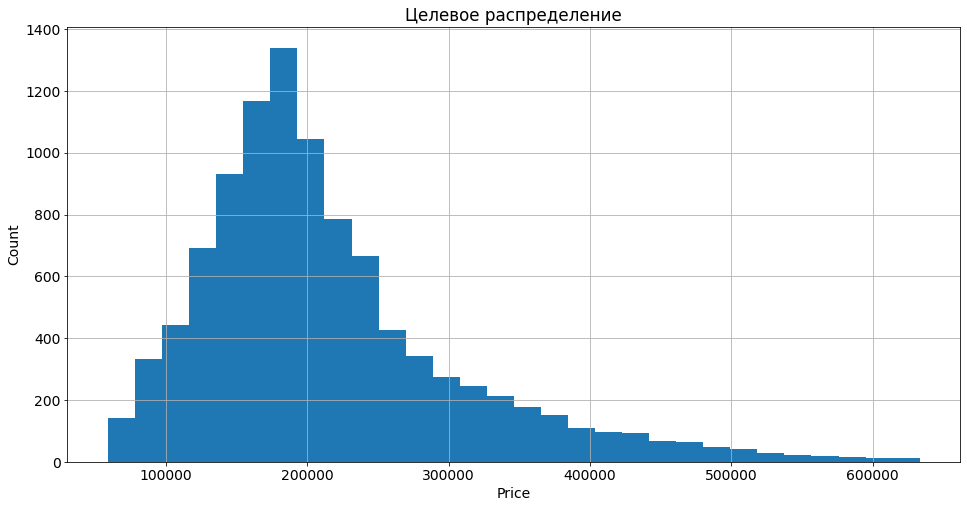

In [15]:
plt.figure(figsize = (16, 8))
train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Целевое распределение')
plt.show()

In [16]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Номинативные переменные

In [17]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [18]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

In [19]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [20]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [21]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

2. Обработка выбросов

Rooms

In [22]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Введём новый столбец 'Rooms_outlier' и присвоим 0, или 1 если 'Rooms' == 0 или >=6

In [23]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | train_df['Rooms'] >= 6, 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [24]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [25]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

KitchenSquare

In [26]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

In [27]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(0.025)

(13.0, 0.0)

In [28]:
condition = train_df['KitchenSquare'].isna() | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [29]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

HouseFloor, Floor

In [30]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [31]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [32]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [33]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [34]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [35]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

Если этаж квартиры больше этажности дома, то проставляем этаж квартиры с помощью random

In [36]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

Проверяем есть ли этаж квартиры, которые превышают этажность дома

In [37]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

HouseYear

In [38]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [39]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

Обработка пропусков

In [40]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

In [41]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,3.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,3.0
9,79.867477,75.085125,3.0


Поработаем с пропусками в LifeSquare.

Если жилая площадь пустая но при этом не пустая площадь кухни и не пустая жилая площадь, то из общей площади вычтем площадь кухни

In [42]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna()

condition = (train_df['LifeSquare'].isna()) & (~train_df['KitchenSquare'].isna()) & (~train_df['Square'].isna())

train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] - train_df.loc[condition, 'KitchenSquare'] - 3

Поработаем с пропусками в Healthcare_1

In [43]:
# Попробуем просто дропнуть
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [44]:
class DataPreprocessing():

  def __init__(self):
    self.medians=None
    self.kitchen_square_quantile=None

  def fit(self, X):
    self.medians=X.median()
    self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
  
  def transform(self, X):
    
    # Rooms
    X['Rooms_outlier'] = 0
    X.loc[(X['Rooms'] == 0) | X['Rooms'] >= 6, 'Rooms_outlier'] = 1

    X.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
    X.loc[train_df['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']

    # KitchenSquare
    condition = X['KitchenSquare'].isna() | (X['KitchenSquare'] > self.kitchen_square_quantile)
    X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

    X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3

    # HouseFloor, Floor
    X['HouseFloor_outlier'] = 0
    X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
    X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1

    X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']

    floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
    X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

    # HouseYear
    current_year = datetime.now().year
    X['HouseYear_outlier'] = 0
    X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
    X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year

    # Healthcare_1
    if 'Healthcare_1' in X.columns:
      X.drop('Healthcare_1', axis=1, inplace=True)

    # LifeSquare
    X['LifeSquare_nan'] = X['LifeSquare'].isna()
    condition = (X['LifeSquare'].isna()) & (~X['KitchenSquare'].isna()) & (~X['Square'].isna())
    X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3

    X.fillna(self.medians, inplace=True)

    return X

4. Построение новых признаков

Dummies

In [45]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

DistrictSize, IsDistrictLarge

In [46]:
print(train_df['DistrictId'].nunique(), ' уникальных  значений в train')
print(test_df['DistrictId'].nunique(), ' уникальных  значений в test')

205  уникальных  значений в train
201  уникальных  значений в test


In [47]:
district_size = train_df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
...,...,...
200,199,1
201,117,1
202,207,1
203,209,1


In [48]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,3097,0,0,0,1,305018.871089,0,0,True,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,6207,1,1,0,1,177734.553407,0,0,False,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,5261,0,3,1,1,282078.720850,0,0,False,652
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,264,0,0,1,1,168106.007630,0,0,True,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,8667,2,0,6,1,343995.102962,0,0,False,89


In [49]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [50]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

MedPriceByDistrict

In [51]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'median'}).rename(columns={'Price': 'MedPriceByDistrict'})
med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [52]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,0,1,305018.871089,0,0,True,851,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,0,1,177734.553407,0,0,False,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,3,1,1,282078.720850,0,0,False,652,1,244005.272380
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,0,1,1,168106.007630,0,0,True,652,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,6,1,343995.102962,0,0,False,89,0,201584.441255


MedPriceByFloorYear

In [53]:
def floor_to_cat(X):

  X['floor_cat'] = 0

  X.loc[X['Floor'] <= 3, 'floor_cat'] = 1
  X.loc[(X['Floor'] > 3) | (X['Floor'] <= 5), 'floor_cat'] = 2
  X.loc[(X['Floor'] > 5) | (X['Floor'] <= 9), 'floor_cat'] = 3
  X.loc[(X['Floor'] > 9) | (X['Floor'] <= 15), 'floor_cat'] = 4
  X.loc[X['Floor'] > 15, 'floor_cat'] = 5

  return X


def floor_to_cat_pandas(X):
  
  bins = [0, 3, 5, 9, 15, X['Floor'].max()]
  X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

  X['floor_cat'].fillna(-1, inplace=True)

  return X


def year_to_cat(X):

  X['year_cat'] = 0

  X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
  X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
  X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
  X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
  X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
  X.loc[X['HouseYear'] > 2010, 'year_cat'] = 6

  return X


def year_to_cat_pandas(X):

  bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
  X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

  X['year_cat'].fillna(-1, inplace=True)

  return X

In [54]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [55]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0         (3, 5]
1         (5, 9]
2         (0, 3]
3        (9, 15]
4       (15, 42]
          ...   
9995      (0, 3]
9996     (9, 15]
9997      (0, 3]
9998      (0, 3]
9999      (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64, right]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [56]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,1,305018.871089,0,0,True,851,1,213530.788443,6,4
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,177734.553407,0,0,False,78,0,146032.829834,3,4
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,282078.720850,0,0,False,652,1,244005.272380,4,4
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,1,168106.007630,0,0,True,652,1,146735.671740,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,1,343995.102962,0,0,False,89,0,201584.441255,3,5


In [57]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()                                            

,year_cat,floor_cat,MedPriceByFloorYear
0,1,4,343812.494282
1,2,4,509182.957515
2,3,4,185153.002144
3,3,5,173028.982008
4,4,4,224306.434830


In [58]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,305018.871089,0,0,True,851,1,213530.788443,6,4,171802.851363
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,177734.553407,0,0,False,78,0,146032.829834,3,4,185153.002144
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,282078.720850,0,0,False,652,1,244005.272380,4,4,224306.434830
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,168106.007630,0,0,True,652,1,146735.671740,3,4,185153.002144
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,343995.102962,0,0,False,89,0,201584.441255,3,5,173028.982008


In [59]:
class FeatureGenerator():

  def __init__(self):

    self.DistrictId_counts = None
    self.binary_to_numbers = None
    self.med_price_by_district = None
    self.med_price_by_floor_year = None
    self.house_year_max = None
    self.floor_max = None

  def fit(self, X, y=None):

    X = X.copy()

    # Binary features
    self.binary_to_numbers = {'A': 0, 'B': 1}

    # DistrictId
    self.district_size = X['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
    # print(self.district_size)

    # District, Rooms
    df = X.copy()

    if y is not None:
      df['Price'] = y.values

      self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'median'}).\
                                      rename(columns={'Price': 'MedPriceByDistrict'})
      self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()

    # floor, year
    if y is not None:
      self.floor_max = df['Floor'].max()
      self.house_year_max = df['HouseYear'].max()
      df['Price'] = y.values
      df = self.floor_to_cat(df)
      df = self.year_to_cat(df)
      self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                        rename(columns={'Price':'MedPriceByFloorYear'})
      self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()


  def transform(self, X):
    
    # Binary features
    X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)   # self.binary_to_numbers = {'A': 0, 'B': 1}
    X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
    X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)

    # DistrictId, IsDistrictLarge
    X = X.merge(self.district_size, on='DistrictId', how='left')

    X['new_district'] = 0
    X.loc[X['DistrictSize'].isna(), 'new_district'] = 1

    X['DistrictSize'].fillna(5, inplace=True)
    X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)

    # More categorical feauters
    X = self.floor_to_cat(X)
    X = self.year_to_cat(X)

    # Target encoding
    if self.med_price_by_district is not None:
      X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
      X.fillna(self.med_price_by_district_median, inplace=True)

    if self.med_price_by_floor_year is not None:
      X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
      X.fillna(self.med_price_by_floor_year_median, inplace=True)

    return X


  def floor_to_cat(self, X):

    bins = [0, 3, 5, 9, 15, self.floor_max]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    X['floor_cat'].fillna(-1, inplace=True)

    return X


  def year_to_cat(self, X):

    bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    X['year_cat'].fillna(-1, inplace=True)

    return X

5. Отбор признаков

In [60]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [61]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2',]

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize', 'new_district',
                     'IsDistrictLarge', 'MedPriceByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'                                   

6. Разбиение на train и test

In [62]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [63]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [64]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [65]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 29), (3300, 29), (5000, 29))

In [66]:
len(new_feature_names)

9

In [67]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [68]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

7. Построение модели

In [69]:
!pip install lightautoml

     |████████████████████████████████| 294 kB 25.2 MB/s 
     |████████████████████████████████| 76.1 MB 1.2 MB/s 
     |████████████████████████████████| 804.1 MB 2.4 kB/s 
     |████████████████████████████████| 212 kB 86.2 MB/s 
     |████████████████████████████████| 1.2 MB 61.9 MB/s 
     |████████████████████████████████| 425 kB 84.9 MB/s 
     |████████████████████████████████| 308 kB 69.7 MB/s 
     |████████████████████████████████| 2.8 MB 50.6 MB/s 
     |████████████████████████████████| 210 kB 67.4 MB/s 
     |████████████████████████████████| 81 kB 12.3 MB/s 
     |████████████████████████████████| 78 kB 9.5 MB/s 
     |████████████████████████████████| 150 kB 68.7 MB/s 
     |████████████████████████████████| 113 kB 68.0 MB/s 
     |████████████████████████████████| 49 kB 8.5 MB/s 
     |████████████████████████████████| 21.0 MB 1.4 MB/s 
     |████████████████████████████████| 23.2 MB 1.4 MB/s 
     |████████████████████████████████| 23.3 MB 81.8 MB/s 
     |███████████

Обучение

In [70]:
# rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model = RandomForestRegressor(random_state=56, max_depth=15, max_features=5, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', max_depth=15, max_features=5,
                      random_state=56)

Оценка модели

Train R2:	0.947
Test R2:	0.724


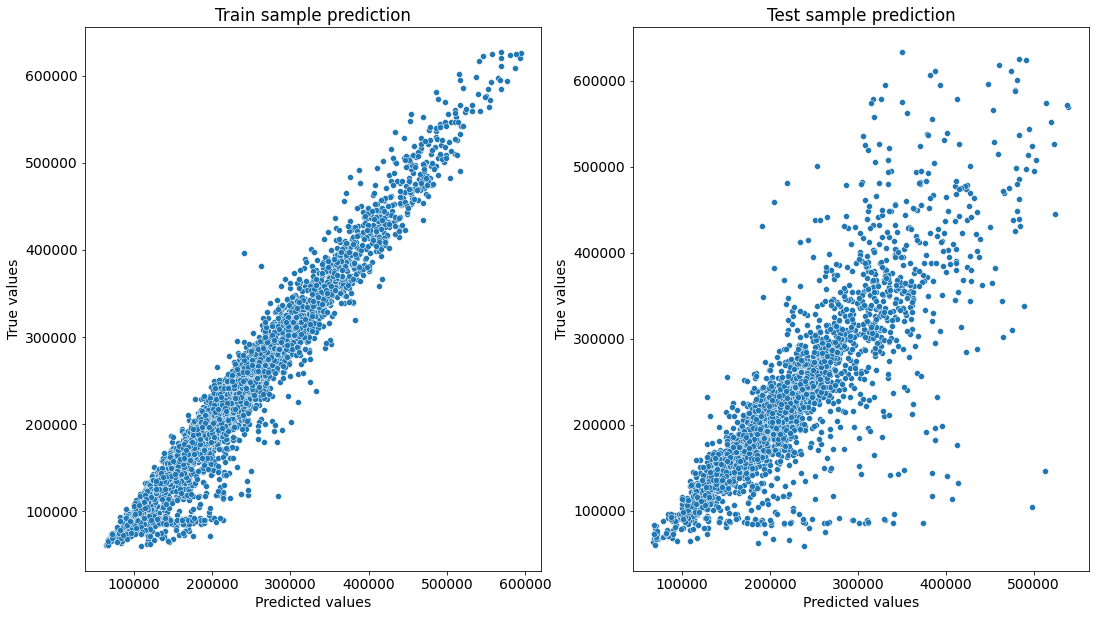

In [71]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Кросс-валидация

In [72]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.77426645, 0.73862943, 0.75980052])

In [73]:
cv_score.mean()

0.7575654661766754

Важность признаков

In [74]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
23,MedPriceByDistrict,0.288589
1,Square,0.187805
0,Rooms,0.082434
2,LifeSquare,0.067613
20,DistrictSize,0.057571
11,Social_2,0.044984
10,Social_1,0.035296
12,Social_3,0.030575
6,HouseYear,0.029343
22,IsDistrictLarge,0.029122


Прогнозирование на тестовом датасете

In [75]:
test_df.shape

(5000, 25)

In [76]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [77]:
predictions = rf_model.predict(test_df)
predictions

array([158028.45001656, 122384.57230667, 141241.10535061, ...,
       148208.63263098, 189251.84350001, 237210.30881549])

In [78]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,158028.450017
1,5925,122384.572307
2,960,141241.105351
3,3848,141233.455910
4,746,194071.945746


In [79]:
test_df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,MedPriceByDistrict,MedPriceByFloorYear
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,1,0,0,0,False,76.0,0,0,171145.169069,189098.430014
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,...,0,0,0,0,False,164.0,0,1,131107.271962,178912.369081
2,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,1,1,...,1,0,0,0,True,580.0,0,1,165993.292450,173028.982008
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,1,0,0,0,False,372.0,0,1,172778.615365,180289.153080
4,1.0,53.837056,47.837056,3.0,8,17.0,1977,0.309479,1,1,...,1,0,0,0,True,65.0,0,0,164116.183543,191935.165175


In [80]:
submit.to_csv('rf_submit.csv', index=False)

Light auto ML

In [81]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.tasks.common_metric import mean_quantile_error, rmsle

In [82]:
TARGET_NAME = target_name

In [83]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

preprocessor = DataPreprocessing()
preprocessor.fit(train_df)

X_train = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

features_gen = FeatureGenerator()
features_gen.fit(X_train, X_train[TARGET_NAME])

X_train = features_gen.transform(X_train)
test_df = features_gen.transform(test_df)

In [84]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,0,0,False,104.0,0,1,1.0,2,171145.169069,189476.595202
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,...,0,0,False,247.0,0,1,2.0,5,129107.218932,172652.431537
2,960,27,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,...,0,0,True,851.0,0,1,4.0,2,165683.084779,173028.982008
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,0,0,False,565.0,0,1,0.0,2,166687.735824,179675.490715
4,746,74,1.0,53.837056,47.837056,3.0,8,17.0,1977,0.309479,...,0,0,True,114.0,0,1,2.0,2,165071.825722,191935.165175


In [85]:
TASK = Task('reg', loss='mse', metric=rmsle, greater_is_better=False)
TIMEOUT = 300000
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TARGET_NAME = 'Price'
TEST_SIZE = 0.2

In [86]:
roles = {'target': TARGET_NAME, 'drop': ['Id']}

In [93]:
automl_model = TabularAutoML(task=TASK,
                             timeout=TIMEOUT,
                             cpu_limit=N_THREADS,
                             gpu_ids='all',
                             reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                             general_params={'use_algos': [['lgb_tuned', 'cb_tuned', 'cb'], ['lgb_tuned', 'cb']]},
                             tuning_params={'max_tuning_iter': 10},
                             )

In [94]:
oof_pred = automl_model.fit_predict(X_train, roles = roles)


In [95]:
test_df['Price'] = automl_model.predict(test_df).data

In [96]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear,Price
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,0,False,104.0,0,1,1.0,2,171145.169069,189476.595202,166237.562500
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,...,0,False,247.0,0,1,2.0,5,129107.218932,172652.431537,119203.203125
2,960,27,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,...,0,True,851.0,0,1,4.0,2,165683.084779,173028.982008,137718.343750
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,0,False,565.0,0,1,0.0,2,166687.735824,179675.490715,115630.906250
4,746,74,1.0,53.837056,47.837056,3.0,8,17.0,1977,0.309479,...,0,True,114.0,0,1,2.0,2,165071.825722,191935.165175,177642.718750


In [97]:
test_df.to_csv('sabmission_LAMA.csv', columns=['Id', 'Price'], index=False)